In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

In [2]:
df = pd.read_excel('dataset.xlsx', 1)
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


In [3]:
from lifetimes.utils import summary_data_from_transaction_data

data = summary_data_from_transaction_data(df, 'UserId', 'OrderDate', 
                                          observation_period_end='2010-01-09',
                                         monetary_value_col='TotalCharges')
data.head()

,frequency,recency,T,monetary_value
UserId,,,,
47,55.0,358.0,363.0,45.265240
95,1.0,28.0,305.0,3.680000
98,7.0,96.0,345.0,5.144286
112,0.0,0.0,355.0,0.000000
141,0.0,0.0,57.0,0.000000


In [22]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(data['frequency'], data['recency'], data['T'])

bgf

<lifetimes.BetaGeoFitter: fitted with 569 subjects, a: 0.46, alpha: 13.22, b: 3.17, r: 0.31>

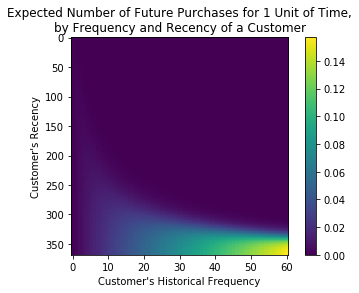

In [5]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

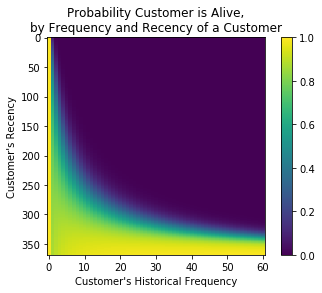

In [6]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [7]:
t = 1 # values from 0.1 to 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(10)

,frequency,recency,T,monetary_value,predicted_purchases
UserId,,,,,
136879,6.0,42.0,46.0,216.095933,0.097738
101947,8.0,62.0,64.0,25.818600,0.101673
101944,9.0,71.0,72.0,17.075444,0.104242
45949,19.0,152.0,156.0,124.162932,0.110198
61628,16.0,122.0,123.0,35.791100,0.116256
134462,9.0,50.0,56.0,75.119822,0.122489
38857,24.0,148.0,152.0,37.699154,0.142439
47,55.0,358.0,363.0,45.265240,0.144510
253,60.0,366.0,368.0,88.395430,0.156531


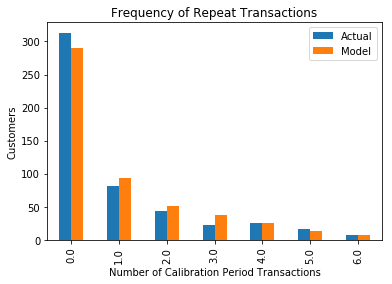

In [8]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [9]:
from lifetimes.utils import calibration_and_holdout_data

calibration_data = calibration_and_holdout_data(df, 'UserId', 'OrderDate',
                                              calibration_period_end='2009-12-15',
                                              observation_period_end='2010-01-09')
calibration_data.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
UserId,,,,,
47,53.0,337.0,338.0,2.0,25
95,1.0,28.0,280.0,0.0,25
98,7.0,96.0,320.0,0.0,25
112,0.0,0.0,330.0,0.0,25
141,0.0,0.0,32.0,0.0,25


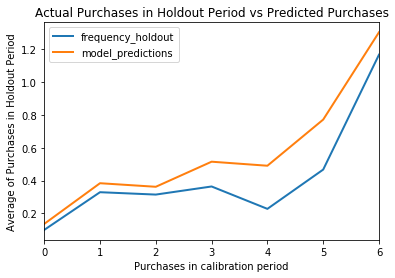

In [10]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(calibration_data['frequency_cal'], calibration_data['recency_cal'], calibration_data['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, calibration_data)

In [11]:
with_frequency = data[data['frequency']>0]
with_frequency.head()

,frequency,recency,T,monetary_value,predicted_purchases
UserId,,,,,
47,55.0,358.0,363.0,45.265240,0.144510
95,1.0,28.0,305.0,3.680000,0.001332
98,7.0,96.0,345.0,5.144286,0.000069
180,1.0,125.0,235.0,46.050200,0.004024
200,5.0,195.0,277.0,8.458000,0.013338


In [12]:
with_frequency[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.152258
frequency,0.152258,1.000000


In [18]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(with_frequency['frequency'], with_frequency['monetary_value'])

ggf

<lifetimes.GammaGammaFitter: fitted with 256 subjects, p: 2.19, q: 3.19, v: 58.37>

In [19]:
ggf.conditional_expected_average_profit(
    data['frequency'],
    data['monetary_value']
).head(20)

UserId
47      45.500437
95      31.046892
98      11.799226
112     58.456468
141     58.456468
160     58.456468
180     52.248500
182     58.456468
200     16.780261
202    155.403639
207     42.824171
225     58.456468
230     32.818848
253     87.905379
277    147.809278
407     58.456468
457     60.203597
464     58.456468
550    105.781861
616    114.484573
dtype: float64

In [20]:
"Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).mean(),
    data[data['frequency']>0]['monetary_value'].mean()
)

'Expected conditional average profit: 57.7085788394, Average profit: 54.3786457162'

In [21]:
bgf.fit(data['frequency'], data['recency'], data['T'])

ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=2, # months
    discount_rate=0.1 # monthly discount rate
).head(10)

UserId
47     331.651713
95       2.111651
98       0.041484
112      2.517006
141     12.595720
160     21.212423
180     10.676364
182      2.572203
200     11.294016
202    277.190270
Name: clv, dtype: float64